# Initial data engineering notebook
This notebook is responsible for the first processing step of the raw data provided by pathologists.
It is capable of processing data provided in .vsi and .geojson format and outputs something thats easily usable later, i.e. numpy arrays.

The notebook itself is split into 3 parts.
1. Extraction of multiclass structure segmentation data
2. Extraction of multilabeling structure segmentation data
3. Extraction of background masks 

In [3]:
import os
import numpy as np
import tifffile as tiff
import geopandas as gpd
import re
import fiona
import cv2
import time
import geojson
import json

from skimage.draw import polygon
from skimage.draw import polygon, polygon2mask
from itertools import tee
from shapely.geometry import shape
from shapely.geometry import Polygon, mapping
from PIL import Image
from glob import glob

from multiprocess import Pool
from matplotlib import pyplot as plt

## Multiclass structure segmentation data

In [24]:
# Lookup table for geojson structures
# Key - polygon classification.name
# Value - encoded value for the output mask
mapping_dict = {
    "Endocarium": 1,
    "Blood vessels": 2,
    "Inflammation": 3,
    "Fatty tissue": 4,
    "Immune cells": 5,
    "Quilty": 6,       
    "Fibrotic tissue": 7,  
}
drop = [] # Specify classes you want to skip

def process_file(file, time=time, glob=glob, gpd=gpd, tiff=tiff, np=np, polygon=polygon, mapping=mapping, mapping_dict=mapping_dict, drop=drop):
    start = time.time()
    
    # Extract wsi idx and find relevant geojsons
    if 'test' not in file:
        idx = file.split(".")[0]
    else:
        idx = file.split("-")[0]
    anno_path = glob(f'./qupath_project/ivan-annotations/{idx}*annotations.geojson')
    
    # IKEM annotations don't have consistent labeling
    if len(anno_path) == 0:
        anno_path = glob(f'./qupath_project/ivan-annotations/{idx}*20x.geojson')
    anno = gpd.read_file(anno_path[0])
    
    # tifffile to load images - just gives you an rgb numpy array - used to extract the final shape
    if idx not in ["3002", "7026"]:
        wsi = tiff.imread(f'./raw_data/tif_export/{idx}.ome.tif')
    else:
        wsi = tiff.imread(f'./raw_data/tif_export/{idx}-test.tif')
        
    # Create an outmask of the correct size
    out_mask = np.zeros((wsi.shape[:-1]), dtype=np.uint8)
    
    # Iterate and draw polygons. Explode splits multipolygons into multiple polygons :)))))))))))))))))))))))))))))
    for row_idx, row in anno.explode().iterrows():
        if  row.classification is None or row.classification['name'] in drop:
            continue
            
        # Every classification type has to be in the lookup table
        if row.classification['name'] not in mapping_dict:
            raise Exception(f"Class {row.classification['name']} not mapped")
        try:
            # Gets the coordinates of the polygon's outline
            exterior_pol = polygon(np.array(row.geometry.exterior.coords[:])[:, 0], np.array(row.geometry.exterior.coords[:])[:, 1])
        except ValueError:
            print(row_idx, row.geometry)

        # Extract x, y coordinate pairs from the shapely polygon
        out_pol = []
        for (r, c) in zip(np.array(exterior_pol)[0], np.array(exterior_pol)[1]):
            out_pol.append((c, r))

        # This is just a hacky way of prioritising inflammation in my data, not necessary
        for point in out_pol:
            if out_mask[point[0], point[1]] != 2:
                out_mask[point[0], point[1]] = mapping_dict[row.classification['name']]
            
        # Plots out the 'holes' (interior details) in the polygon
        for interior in row.geometry.interiors:
            interior_pol = polygon(np.array(interior.coords[:])[:, 0], np.array(interior.coords[:])[:, 1])
            out_mask[np.array(interior_pol)[1], np.array(interior_pol)[0]] = 0
    
    with open(f'./raw_data/class_masks_fix/{idx}_classes.npy', 'wb') as f:
        np.save(f, out_mask.astype(np.uint8))
    print(f"File {idx} processed in {time.time() - start} s")
    return out_mask


In [25]:
# %%time
with Pool(len(['5312.ome.tif', '4742.ome.tif'])) as p:
    p.map(process_file, ['5312.ome.tif', '4742.ome.tif'])

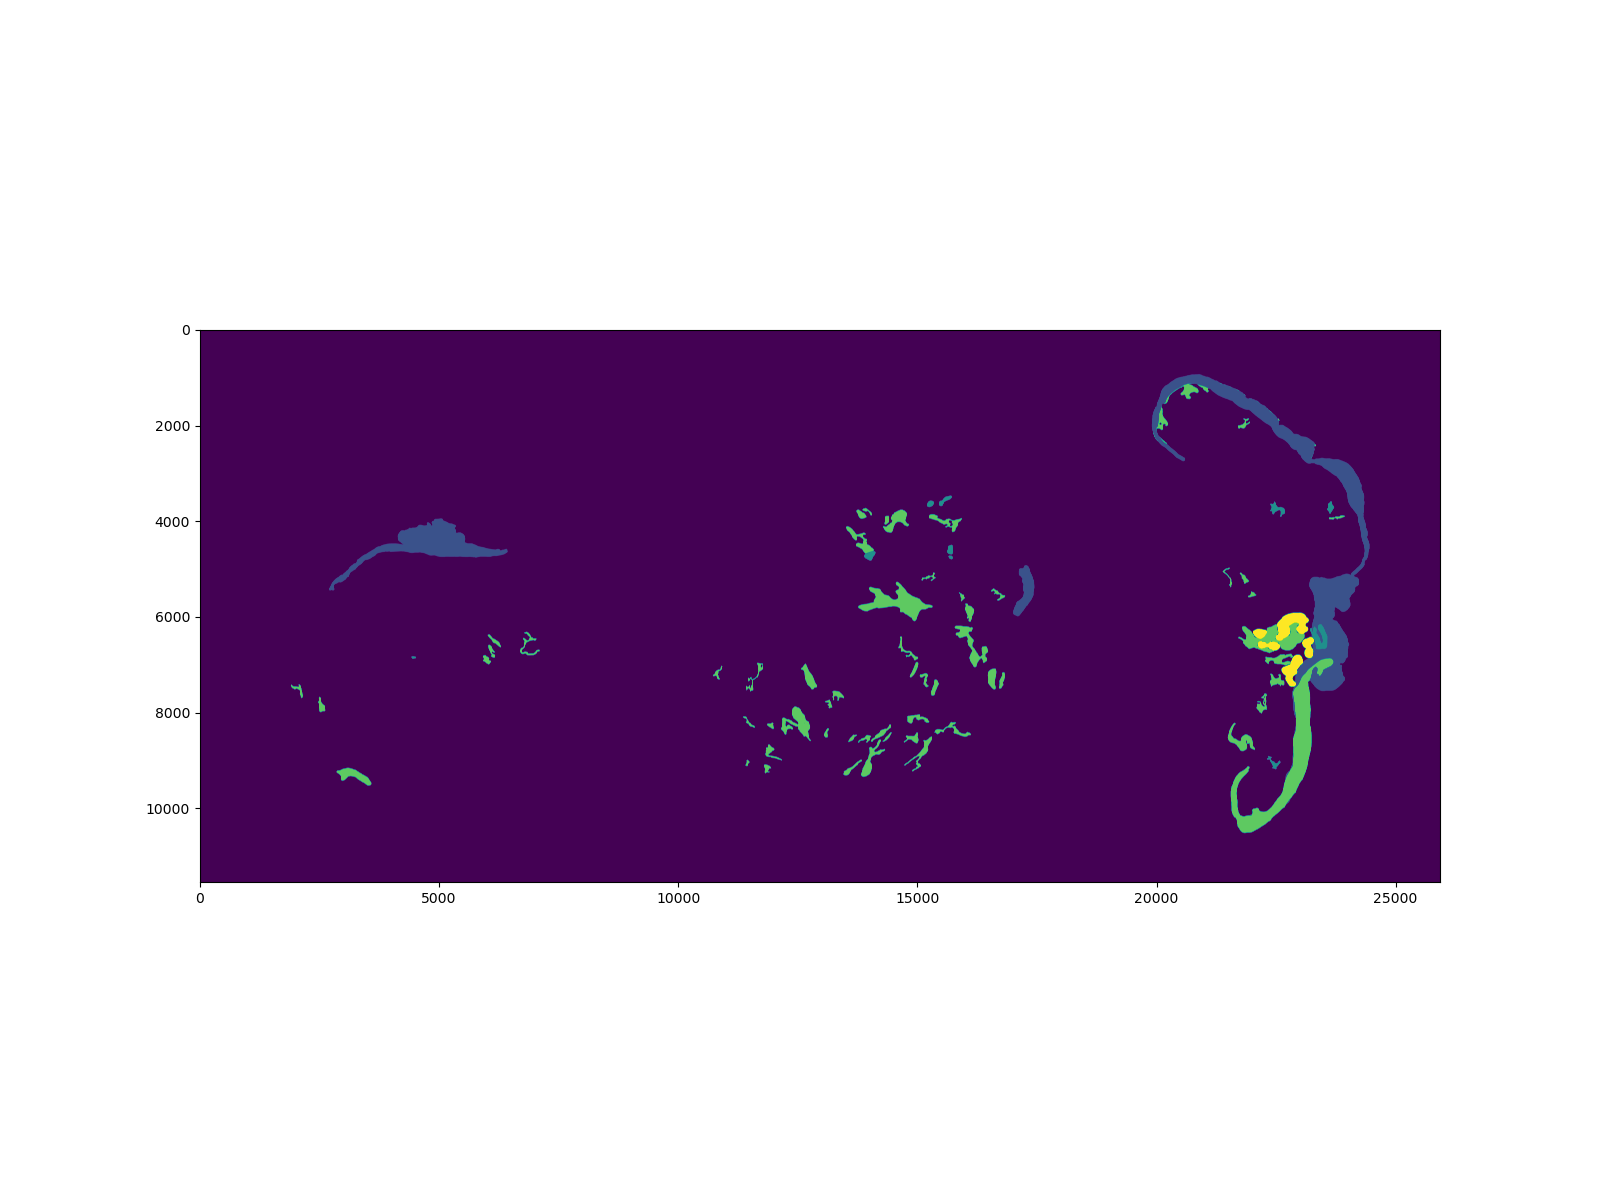

In [28]:
%matplotlib widget
plt.figure(figsize=(16, 12))
plt.imshow(np.load(f'./raw_data/class_masks_fix/{5312}_classes.npy'))

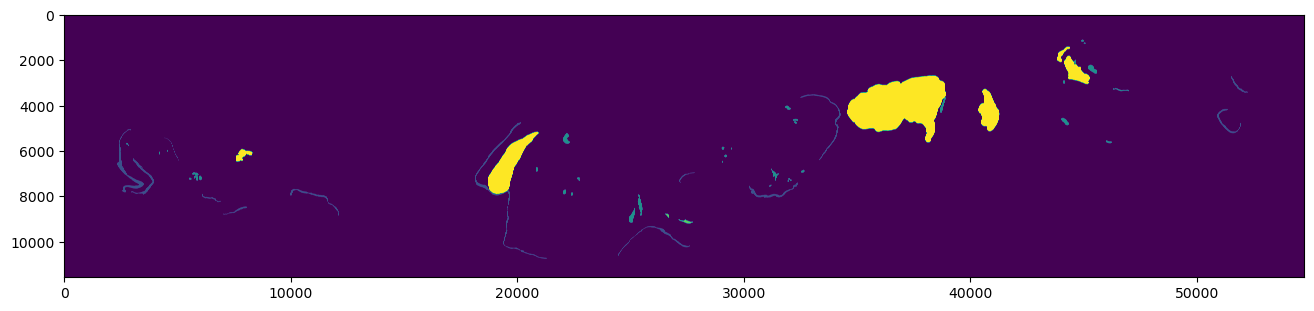

In [200]:
plt.figure(figsize=(16, 12))
plt.imshow(test_mask)

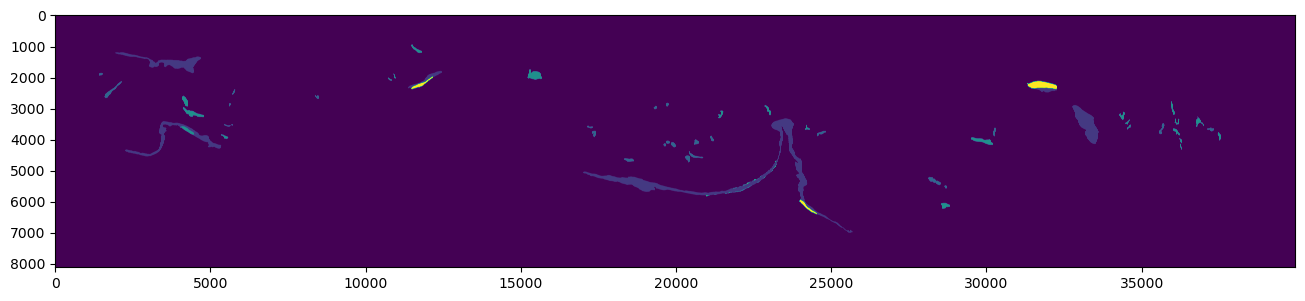

In [20]:
plt.figure(figsize=(16, 12))
plt.imshow(np.load("./class_masks/4987_classes.npy"))

## Multilabel structure segmentation data

In [14]:
# Lookup table for geojson structures
# Key - polygon classification.name
# Value - encoded value for the output mask
mapping_dict = {
            "Endocarium": 1,
            "Blood vessels": 2,
            "Inflammation": 3,
            "Fatty tissue": 4,
            "Immune cells": 3,
            "Quilty": 3,  # first appearence - file idx 8, 4987, also contains None classifications
            "Fibrotic tissue": 1,  # first appearence 4987, 7169
        }
drop = [] # Specify classes you want to skip

def process_file(file, time=time, glob=glob, gpd=gpd, tiff=tiff, np=np, polygon=polygon, mapping=mapping, mapping_dict=mapping_dict, drop=drop):
    start = time.time()
    
    # Extract wsi idx and find relevant geojsons
    if 'test' not in file:
        idx = file.split(".")[0]
    else:
        idx = file.split("-")[0]
    anno_path = glob(f'./qupath_project/ivan-annotations/{idx}*annotations.geojson')
    
    # IKEM annotations don't have consistent labeling
    if len(anno_path) == 0:
        anno_path = glob(f'./qupath_project/ivan-annotations/{idx}*20x.geojson')
        
    if len(anno_path) == 0:
        anno_path = glob(f'./qupath_additional/{idx}_22.vsi - 20x_annotations.geojson')
        
    anno = gpd.read_file(anno_path[0])
    
    # tifffile to load images - just gives you an rgb numpy array - used to extract the final shape
    if idx not in ["3002", "7026"]:
        wsi = tiff.imread(f'./raw_data/tif_export/{idx}.ome.tif')
    else:
        wsi = tiff.imread(f'./raw_data/tif_export/{idx}-test.tif')
        
    # Create an outmask of the correct size
    out_mask = np.zeros((5, wsi.shape[0], wsi.shape[1]), dtype=np.uint8)
    out_mask[0] = 1
    
    # Iterate and draw polygons. Explode splits multipolygons into multiple polygons :)))))))))))))))))))))))))))))
    for row_idx, row in anno.explode().iterrows():
        if  row.classification is None or row.classification['name'] in drop:
            continue
            
        # Every classification type has to be in the lookup table
        if row.classification['name'] not in mapping_dict:
            raise Exception(f"Class {row.classification['name']} not mapped")
        try:
            # Gets the coordinates of the polygon's outline
            exterior_pol = polygon(np.array(row.geometry.exterior.coords[:])[:, 0], np.array(row.geometry.exterior.coords[:])[:, 1])
        except ValueError:
            print(row_idx, row.geometry)

        # Extract x, y coordinate pairs from the shapely polygon
        out_pol = []
        for (r, c) in zip(np.array(exterior_pol)[0], np.array(exterior_pol)[1]):
            out_pol.append((c, r))

        # This is just a hacky way of prioritising inflammation in my data, not necessary
        for point in out_pol:
            out_mask[mapping_dict[row.classification['name']], point[0], point[1]] = 1
            out_mask[0, point[0], point[1]] = 0
            
        # Plots out the 'holes' (interior details) in the polygon
        for interior in row.geometry.interiors:
            interior_pol = polygon(np.array(interior.coords[:])[:, 0], np.array(interior.coords[:])[:, 1])
            out_mask[mapping_dict[row.classification['name']], np.array(interior_pol)[1], np.array(interior_pol)[0]] = 0
            out_mask[0, np.array(interior_pol)[1], np.array(interior_pol)[0]] = 1
    
    with open(f'./raw_data/class_masks_multilabel/{idx}_classes.npy', 'wb') as f:
        np.save(f, out_mask.astype(np.uint8))
    print(f"File {idx} processed in {time.time() - start} s")
    return out_mask


In [4]:
src_files = os.listdir('./raw_data/tif_export')
dst_files = os.listdir('F:/Halinkovic/IKEM/raw_data/class_masks_multilabel')

In [7]:
process_files = [file for file in src_files if 'test' not in file and int(file.split('.')[0]) in [6460, 6417, 4843, 758, 237] ]

In [15]:
%%time
with Pool(4) as p:
    p.map(process_file, process_files)

CPU times: total: 17.7 s
Wall time: 9min 29s


## Background extraction

In [2]:
%%time
for file in os.listdir('./raw_data/tif_export'):
    start = time.time()
    
    idx = file.split(".")[0]
    if 'test' in idx or int(idx) not in [6460, 6417, 4843, 758, 237]:
        continue
    wsi = tiff.imread(f'./raw_data/tif_export/{idx}.ome.tif')
    wsi = cv2.cvtColor(wsi, cv2.COLOR_RGB2GRAY)
    wsi = cv2.GaussianBlur(wsi, (7, 7), 1)
    bg_mask = np.zeros(wsi.shape, dtype=np.uint8)
    bg_mask = np.where(wsi > 210, 1, 0)
    bg_mask = cv2.morphologyEx(bg_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    bg_mask = cv2.erode(bg_mask.astype(np.uint8), np.ones((30, 30), np.uint8))
    with open(f'./raw_data/bg_masks/{idx}_bg.npy', 'wb') as f:
        np.save(f, bg_mask.astype(np.uint8))
    print(f"File {idx} processed in {time.time() - start} s")

File 237 processed in 32.195125102996826 s
File 4843 processed in 12.82286548614502 s
File 6417 processed in 7.633736848831177 s
File 6460 processed in 11.263569355010986 s
File 758 processed in 17.884082078933716 s
CPU times: total: 49.6 s
Wall time: 1min 21s


In [17]:
%%time
for file in glob(f'./test_data/*.tif'):
    start = time.time()
    idx = file.split('_p')[0].split('\\')[1]
    name = file.split('\\')[1]
    wsi = tiff.imread(file)
    wsi = cv2.cvtColor(wsi, cv2.COLOR_RGB2GRAY)
    wsi = cv2.GaussianBlur(wsi, (7, 7), 1)
    bg_mask = np.zeros(wsi.shape, dtype=np.uint8)
    bg_mask = np.where(wsi > 210, 1, 0)
    bg_mask = cv2.morphologyEx(bg_mask.astype(np.uint8), cv2.MORPH_CLOSE, np.ones((15, 15), np.uint8))
    bg_mask = cv2.erode(bg_mask.astype(np.uint8), np.ones((30, 30), np.uint8))
    with open(f"./raw_data/bg_masks/{name.replace('.tif', '_bg.npy')}", 'wb') as f:
        np.save(f, bg_mask.astype(np.uint8))
    print(f"File {idx} processed in {time.time() - start} s")
    

<tifffile.TiffFile '2724_part_1.tif'> OME series expected 69 frames, got 1
<tifffile.TiffFile '2724_part_1.tif'> OME series cannot handle discontiguous storage ((2133, 3293, 3) != (9586, 50582, 3))
<tifffile.TiffFile '2724_part_2.tif'> OME series expected 9 frames, got 1
<tifffile.TiffFile '2724_part_2.tif'> OME series cannot handle discontiguous storage ((5871, 8803, 3) != (9586, 50582, 3))


File 2724 processed in 0.21934270858764648 s


<tifffile.TiffFile '2724_part_3.tif'> OME series expected 11 frames, got 1
<tifffile.TiffFile '2724_part_3.tif'> OME series cannot handle discontiguous storage ((4919, 8222, 3) != (9586, 50582, 3))


File 2724 processed in 1.695242166519165 s


<tifffile.TiffFile '2724_part_4.tif'> OME series expected 4 frames, got 1
<tifffile.TiffFile '2724_part_4.tif'> OME series cannot handle discontiguous storage ((7840, 14582, 3) != (9586, 50582, 3))


File 2724 processed in 1.3413267135620117 s


<tifffile.TiffFile '2724_part_5.tif'> OME series expected 6 frames, got 1
<tifffile.TiffFile '2724_part_5.tif'> OME series cannot handle discontiguous storage ((6409, 11997, 3) != (9586, 50582, 3))


File 2724 processed in 3.2683138847351074 s


<tifffile.TiffFile '2940_part_1.tif'> OME series expected 4 frames, got 1
<tifffile.TiffFile '2940_part_1.tif'> OME series cannot handle discontiguous storage ((7387, 8640, 3) != (8273, 37442, 3))


File 2724 processed in 2.628948211669922 s


<tifffile.TiffFile '2940_part_2.tif'> OME series expected 5 frames, got 1
<tifffile.TiffFile '2940_part_2.tif'> OME series cannot handle discontiguous storage ((6924, 8310, 3) != (8273, 37442, 3))


File 2940 processed in 2.3259992599487305 s


<tifffile.TiffFile '2940_part_3.tif'> OME series expected 19 frames, got 1
<tifffile.TiffFile '2940_part_3.tif'> OME series cannot handle discontiguous storage ((3879, 4122, 3) != (8273, 37442, 3))


File 2940 processed in 2.2288973331451416 s


<tifffile.TiffFile '2940_part_4.tif'> OME series expected 14 frames, got 1
<tifffile.TiffFile '2940_part_4.tif'> OME series cannot handle discontiguous storage ((3813, 5588, 3) != (8273, 37442, 3))


File 2940 processed in 0.8205456733703613 s
File 2940 processed in 0.7677760124206543 s
CPU times: total: 20.5 s
Wall time: 15.3 s


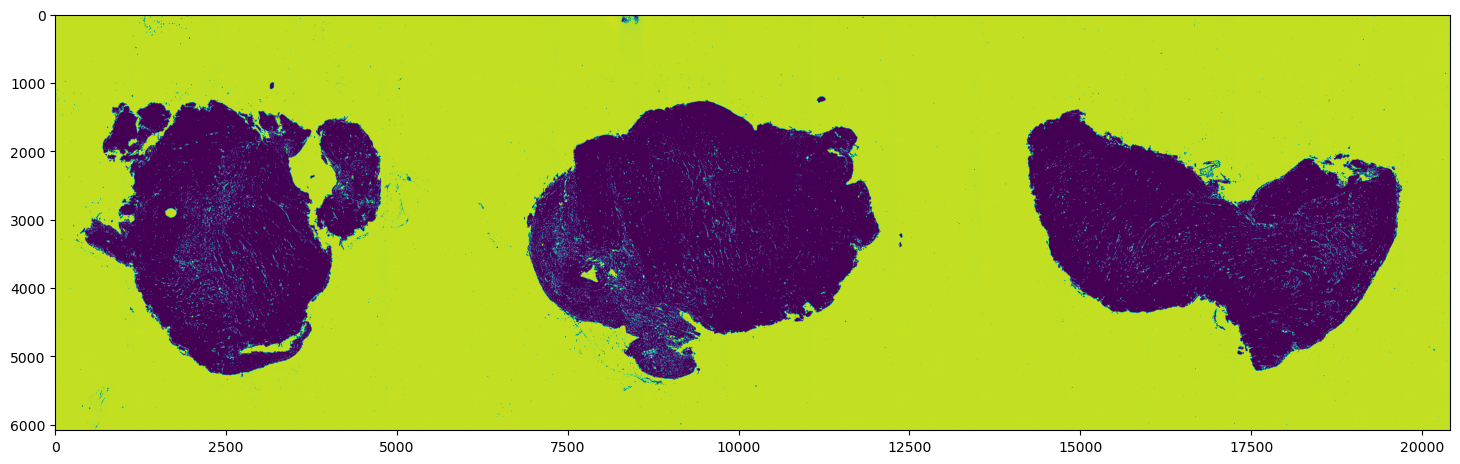

In [69]:
from matplotlib import pyplot as plt
plt.figure(figsize=(18, 12))
plt.imshow(wsi * bg_mask)